In [24]:
IDENTIFIER = "beethoven-op67"
NUM = 1

picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.optimize import curve_fit
import json
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from qubo import createBQM

from qubo import createBQM

phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

{'Flute_1_Flute': 14, 'Flute_2_Flute': 11, 'Flute_3_Flute': 11, 'Flute_4_Flute': 11, 'Flute_5_Flute': 11, 'Oboe_1_Flute': 11, 'Oboe_2_Flute': 11, 'Oboe_3_Flute': 11, 'Oboe_4_Flute': 11, 'Oboe_5_Flute': 11, 'Oboe_6_Flute': 11, 'B♭ Clarinet_1_Flute': 6, 'B♭ Clarinet_2_Flute': 12, 'B♭ Clarinet_3_Flute': 54, 'B♭ Clarinet_4_Flute': 11, 'B♭ Clarinet_5_Flute': 28, 'B♭ Clarinet_6_Flute': 11, 'B♭ Clarinet_7_Flute': 11, 'Bassoon_1_Flute': 26, 'Bassoon_2_Flute': 22, 'Bassoon_3_Flute': 23, 'Bassoon_4_Flute': 11, 'Bassoon_5_Flute': 11, 'Bassoon_6_Flute': 11, 'Horn in E♭_1_Flute': 20, 'Horn in E♭_2_Flute': 11, 'Horn in E♭_3_Flute': 11, 'Horn in E♭_4_Flute': 11, 'C Trumpet_1_Flute': 14, 'C Trumpet_2_Flute': 11, 'C Trumpet_3_Flute': 11, 'C Trumpet_4_Flute': 11, 'C Trumpet_5_Flute': 11, 'Timpani_1_Flute': 14, 'Timpani_2_Flute': 11, 'Timpani_3_Flute': 11, 'Timpani_4_Flute': 11, 'Timpani_5_Flute': 11, 'Violins I_1_Flute': 6, 'Violins I_2_Flute': 5, 'Violins I_3_Flute': 8, 'Violins I_4_Flute': 13, 'Violin

C:\Users\Lucas\AppData\Local\Temp\ipykernel_25448\3542628122.py:5: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  B = bqm.to_networkx_graph()


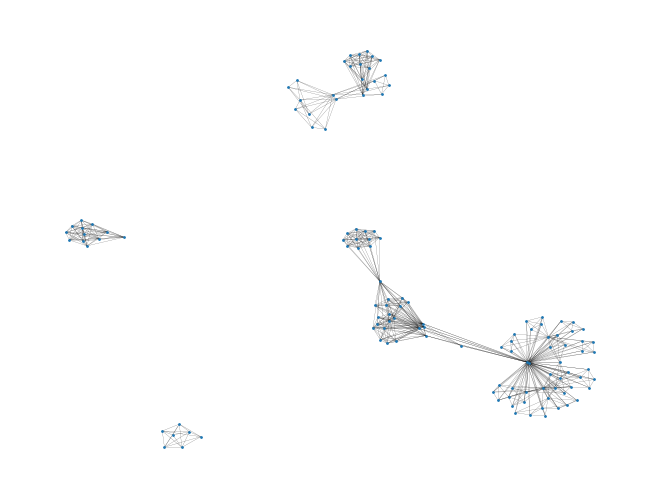

In [25]:
bqm = createBQM(G, phrases, instruments)
print(bqm.degrees())
print(bqm.degrees(array=True).max())

B = bqm.to_networkx_graph()
pos = nx.spring_layout(B, k=.2, scale=2)
nx.draw(B, pos=pos, node_size=1, width=.1)

In [3]:
bqm = createBQM(G, phrases, instruments, 1, 12, 1)
reads = 3000
sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{reads}").to_pandas_dataframe(True).sort_values("energy")

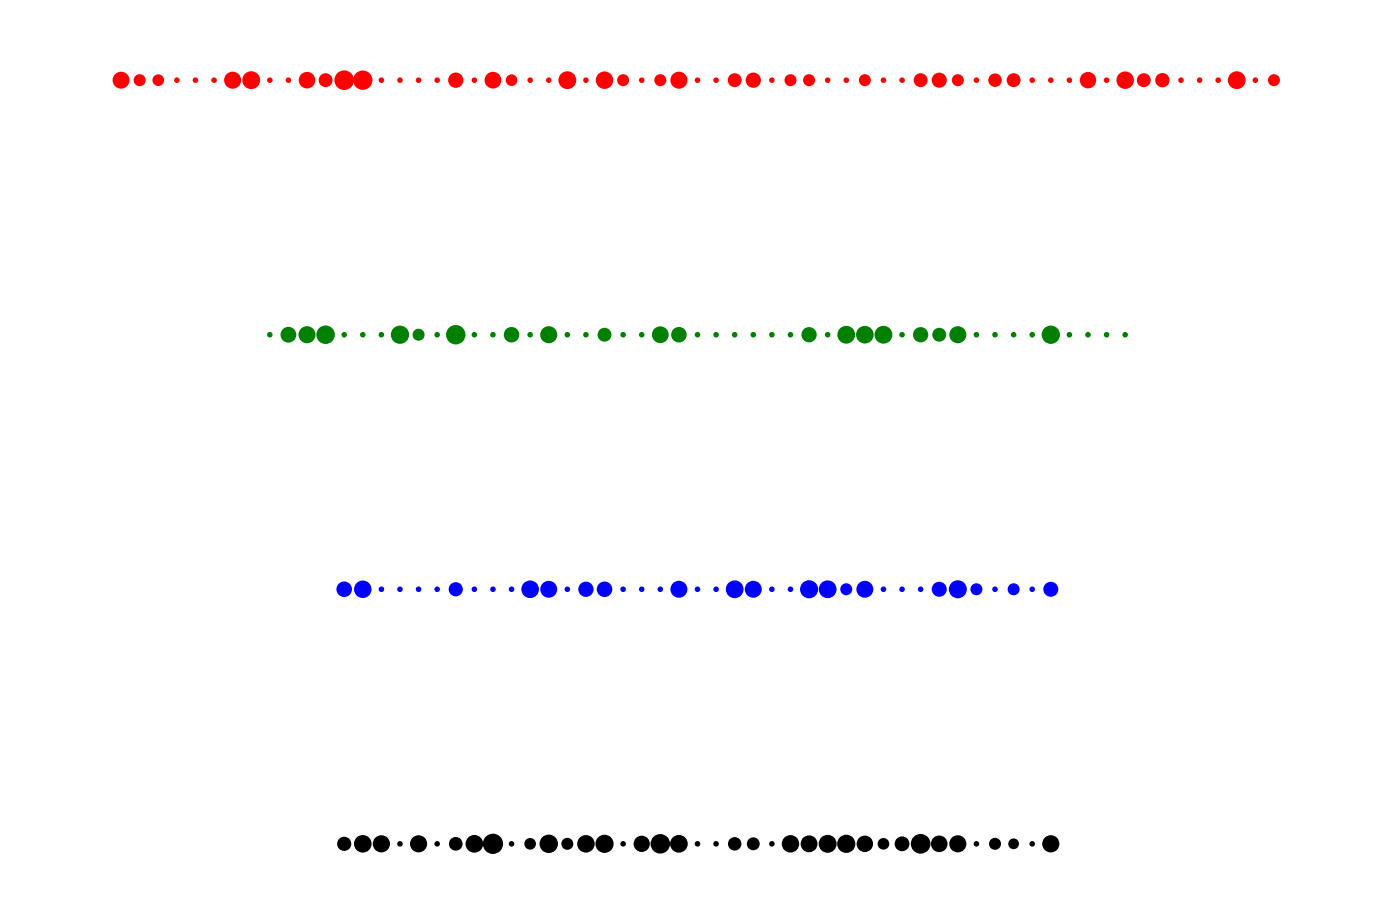

In [10]:
#plotHistogram(sampleset)
def plotSampleGraph(sample: dict, G: nx.Graph) -> None:
    '''
    Plots a sample as a graph.
    '''

    annotated = annotateSampleGraph(sample, G)

    plt.figure(figsize=(9,6),edgecolor=None)
    pos = nx.multipartite_layout(annotated, "colour", "horizontal", 2)

    plt.xticks([])
    plt.yticks([])

    nx.draw(annotated, pos,
            node_color=[annotated.nodes[node]["colour"] for node in annotated.nodes()], node_size=[10*(e[1]+.1) for e in annotated.nodes.data("entropy")],
            width=[d["weight"]/10 for _, _, d in annotated.edges.data()], edge_color="white")
    #nx.draw_networkx_nodes(annotated, pos, node_color=[annotated.nodes[node]["colour"] for node in annotated.nodes()], node_size=[10*(e[1]+.1) for e in annotated.nodes.data("entropy")])
    #nx.draw_networkx_edges(annotated, pos, width=[d["weight"]/10 for _, _, d in annotated.edges.data()], edge_color="white")

plotSampleGraph(sampleset["sample"][0], G)
plt.savefig("../Figures/sample-graph.pdf")

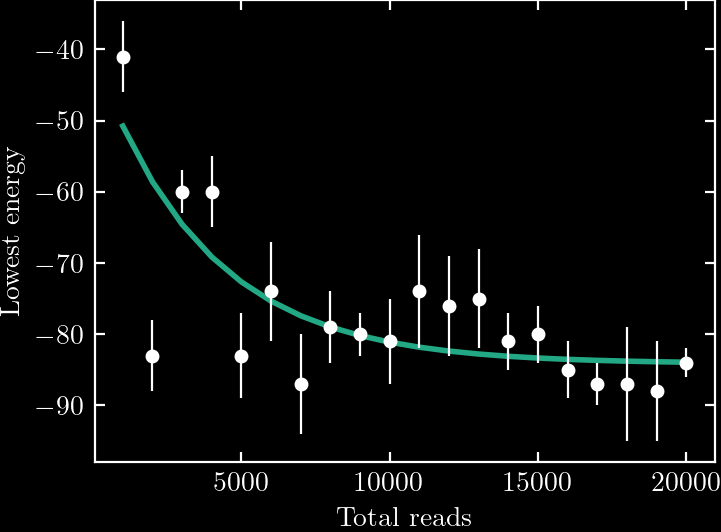

In [4]:
def plotCSV(filepath: str, xaxis: str, yaxis: str, labels: list) -> None:

    data = pd.read_csv(filepath)
    labels = np.array(labels)
    norm = labels.max()

    means = np.empty_like(labels)
    stderr = np.empty_like(labels)

    for i, l in enumerate(labels):
        query = data.query(f"`{xaxis}` == {l}")[yaxis]
        means[i] = np.mean(query)
        stderr[i] = np.std(query)/np.sqrt(len(query))

    fit = lambda x, n, t, c : n*np.exp(-x/t) + c
    coeffs, _ = curve_fit(fit, labels/norm, means, sigma=stderr)
    plt.plot(labels, fit(labels, coeffs[0], norm*coeffs[1], coeffs[2]), ms=0, color=V.TURQUOISE.value, linewidth=2)

    plt.errorbar(labels, means, yerr=stderr, fmt='o', color='white')
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)

#plotCSV(path+"edge-mult.csv", "Multiplier", "Overlaps", range(1,17,1))
plotCSV(path+"total-reads.csv", "Total reads", "Lowest energy", range(1000,20001,1000))
plt.savefig("../Figures/reads.pgf")

In [ ]:
# Draw embedding

P = DWaveSampler().to_networkx_graph()
B = to_networkx_graph(bqm)

dnx.draw_pegasus_embedding(P, embedding, B, node_size=10)

In [ ]:
# Draw graphs

for n in ObjectG.nodes:
    if n.id in chosen:
        n.sol = 1
    else:
        n.sol = 0

cmap = mpl.colormaps['viridis']
nodeSize = 50
edgeColor = "grey"
edgeWidth = 1

pos = nx.spring_layout(ObjectG, k=0.5, seed=9)

plt.figure(0)
nx.draw(ObjectG, pos, nodelist=[], edge_color=edgeColor, width=edgeWidth)
pc0 = nx.draw_networkx_nodes(ObjectG, pos, node_color=[n.entropy for n in ObjectG], cmap=cmap, node_size=nodeSize)
cb = plt.colorbar(pc0, label="Entropy", aspect=30)
plt.gca().set_aspect('equal', "box")

#plt.savefig("..\Figures\problemGraph_pad.pdf", pad_inches=0.1)

plt.figure(1)
nx.draw(ObjectG, pos, nodelist=[], edge_color=edgeColor, width=edgeWidth)
nx.draw_networkx_nodes(ObjectG, pos, alpha=[n.sol for n in ObjectG], node_color=[n.entropy for n in ObjectG], cmap=cmap, node_size=nodeSize)
plt.colorbar(pc0, ax=plt.gca(), label="Entropy", aspect=30)
plt.gca().set_aspect('equal', "box")

#plt.savefig("..\Figures\solutionGraph.pdf", pad_inches=0, bbox_inches="tight")
#plt.savefig("..\Figures\solutionGraph_pad.pdf", pad_inches=0.1)

In [ ]:
lowest_energy = df["energy"][0]
df.query(f"energy == {lowest_energy}")

In [ ]:
# Solution histogram

plt.figure(figsize=(6,4))
N, bins, patches = plt.hist(df["energy"], bins=500, log=True)

norm = mpl.colors.LogNorm(1, N.max())
for thisfrac, thispatch in zip(N, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.xlabel("Energy")
plt.ylabel("Count")
plt.xscale("symlog", linthresh=20, linscale=0.1)
plt.xlim(-30,0)
plt.xticks([-30,-20,-10,0])
#plt.savefig("..\Figures\histogram.pdf", pad_inches=0, bbox_inches="tight")
plt.savefig("..\Figures\histogram_pad.pdf", pad_inches=0.1)

In [ ]:
# Colour selected phrases

phraseStack = pickle.load(open(f"../Pickles/{identifier}_phraseStack.pkl", "rb"))
selected = stream.Score()

for part in phraseStack:
    newPart = stream.Part()
    selected.insert(0,newPart)

    for phrase in part:
        newPart.mergeElements(phrase)
        
        if phrase.id in chosen:
            for el in phrase.notes:
                el.style.color = T.RED.value

selected.show(leaveMargin=50)
selected.write(fmt="musicxml.png", fp="../Figures/selected_trim.png", dpi=300)
selected.write(fmt="musicxml.png", fp="../Figures/selected.png", dpi=300, leaveMargin=50)

In [ ]:
# Remove all except selected

selected = stream.Score()

for i,part in enumerate(phraseStack):
    newPart = stream.Part()
    selected.insert(0,newPart)

    for phrase in part:
        if phrase.id in chosen:
            newPart.mergeElements(phrase)

    if newPart.getInstrument(returnDefault=False) is None:
        newPart.insert(0, part[0].getInstrument())
        newPart.insert(0, part[0].getElementsByClass(key.Key)[0])
        newPart.insert(0, part[0].getTimeSignatures()[0])

selected.show()
#selected.write(fmt="musicxml.png", fp="../Figures/selected.png", dpi=300)

In [ ]:
# Final arrangement

arrangement = stream.Stream()

for phrase in flatStack:
    if phrase.id in chosen:
        arrangement.mergeElements(phrase)

arrangement.show(leaveMargin=50)
arrangement.write(fmt="musicxml.png", fp="../Figures/arrangement_trim.png", dpi=300)
arrangement.write(fmt="musicxml.png", fp="../Figures/arrangement.png", dpi=300, leaveMargin=50)

In [ ]:
# Boundary strength

class BoundaryStrengthAxis(graph.axis.Axis):
    labelDefault = 'Boundary strength'

    def __init__(self, client=None, axisName='y'):
        super().__init__(client, axisName)
        self.minValue = 0
        self.maxValue = 1

    def ticks(self):
        ticks = super().ticks()
        tickValues = [0,1]
        newTicks = [(0,0), (1,1)]
        return newTicks

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'boundaryStrength'):
            return el.boundaryStrength

viola = excerpt.parts[0]
boundaries = identifyBoundaries(viola, 0.4)

plotS = graph.plot.Scatter(viola, marker="o")

plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = BoundaryStrengthAxis(plotS, 'y')
plotS.title = ""
plotS.figureSize = (6,4)

plotS.alpha = 1
plotS.colors = [c.value for c in V]
plotS.labelFontSize = 11
plotS.tickFontSize = 10
plotS.doneAction = None
plotS.axisX.label = "Measure"
plotS.hideYGrid = True

plotS.run()

line = plt.hlines(0.4, 0, viola.quarterLength, linestyles=":", colors="black")
plotS.subplot.add_artist(line)
plotS.subplot.set_xlim(left=0, right=viola.quarterLength)
plotS.subplot.set_ylim(bottom=0, top=1)

plotS.write()
#plotS.write(fp="..\\Figures\\boundaryStrength.pdf")
plt.savefig("..\Figures\\boundaryStrength_pad.pdf", pad_inches=0.1)

In [ ]:
# Generate LaTeX table for phrase properties

table = pd.DataFrame(columns=["Measure", "Boundary strength", "Entropy"])

for p in phraseStack[0]:
    table.loc[len(table)] = [p[0].offset, p.notes[0].boundaryStrength, p.entropy]

table.head()
print(table.to_latex())